In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Latex


   * LINC\_GDP - Labour income as a percentage of GDP
   * dr - Discount rate
   * CU - Capacity utilization
   * OIL - Brent crude
   * INF\_SA - Inflation rate South Africa
   * INF\_ES - Inflation rate Eswatini
   *



$t$ represent time month

   * LINC\_GDP (t-1) 
   * dr (t-26) 
   * CU (t-1) 
   * OIL (t-1) 
   * INF\_SA (t) 
   * INF\_ES (t) 
   * SZL_USD(t)


### Load the data set

In [2]:
data=pd.read_excel('data_final.xlsx')
data = data.drop('MONTH', axis=1)

# List of explanatory variables and the target variable
explanatory_vars = ['INF_SA', 'CU', 'LINC_GDP', 'OIL', 'SZL_USD', 'dr']
target_var = 'INF_ES'

data.head()#top 5 rows

,INF_SA,CU,LINC_GDP,OIL,SZL_USD,dr,INF_ES
0,6.0,0.015322,41.264000,53.52,7.2054,9.0,4.903145
1,5.7,0.014207,41.264923,57.56,7.1703,9.0,6.003028
2,6.2,0.016461,41.265846,60.60,7.3379,9.0,5.999688
3,6.9,0.016750,41.266769,65.06,7.1187,9.0,8.398610
4,7.1,0.013342,41.267692,65.16,7.0170,9.0,7.998349


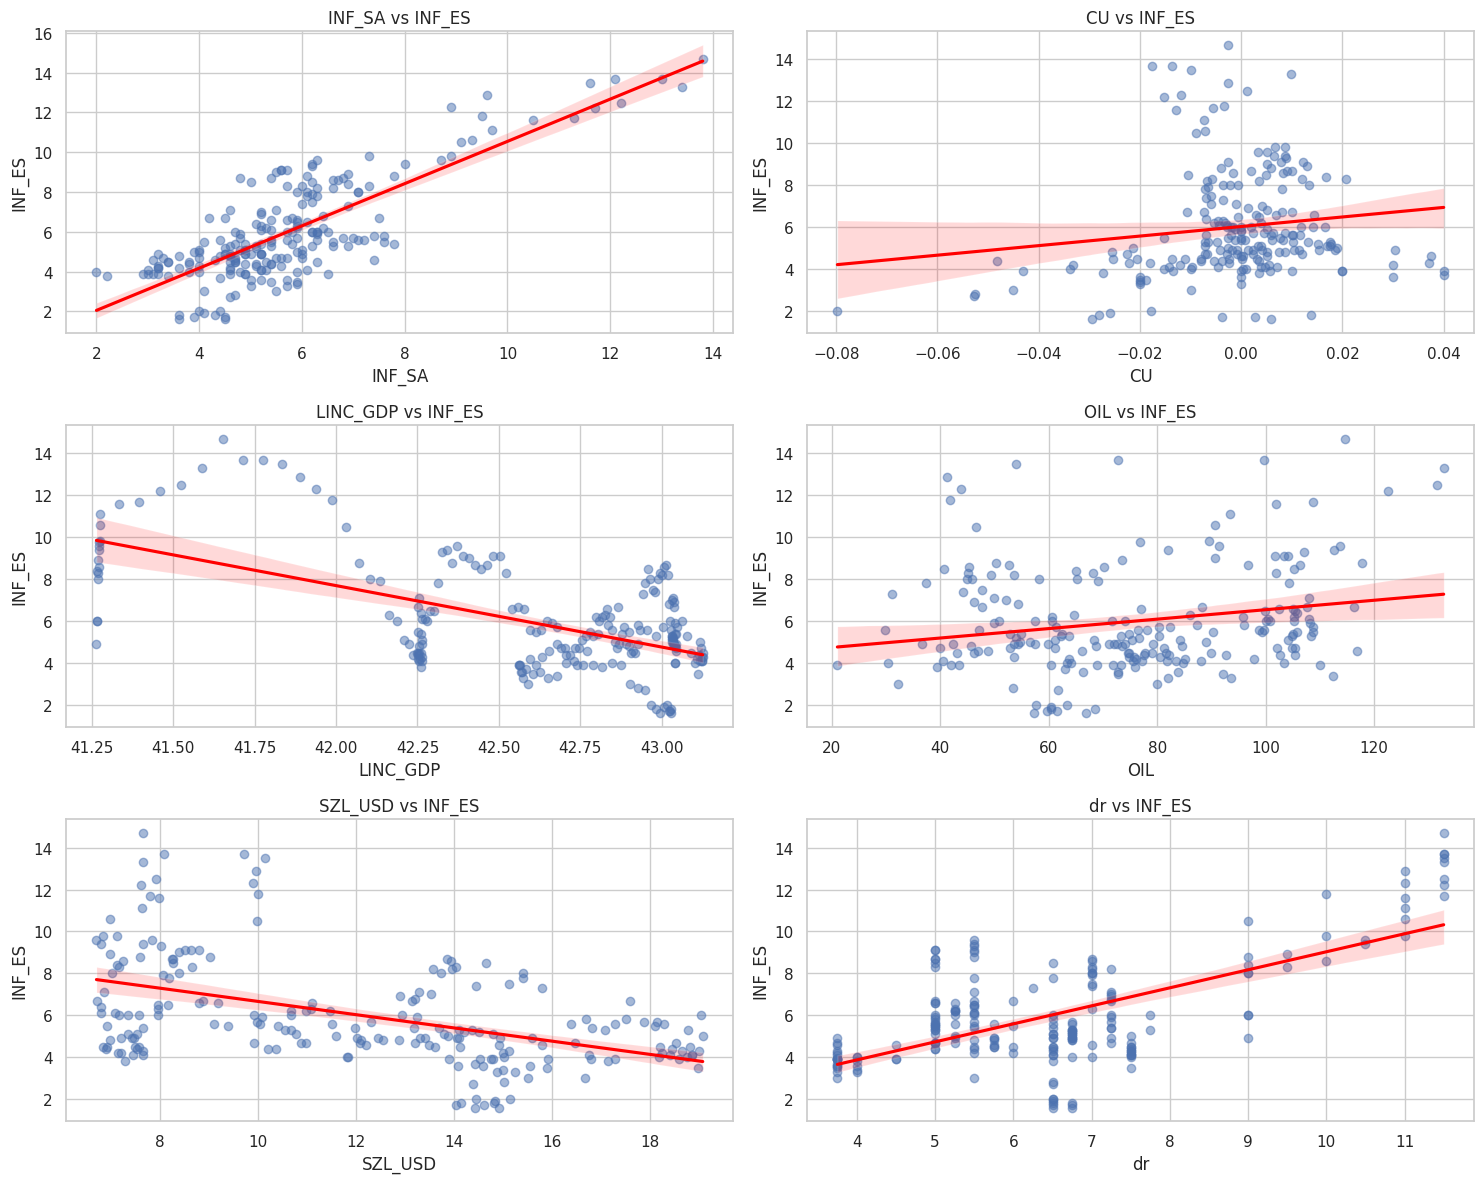

In [6]:

# Set up the plotting environment
plt.figure(figsize=(15, 12))
sns.set(style='whitegrid')


# Creating subplots for each explanatory variable
for i, var in enumerate(explanatory_vars, 1):
    plt.subplot(3, 2, i)  # Creating a 3x2 grid of plots
    sns.regplot(x=data[var], y=data[target_var], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'{var} vs {target_var}')
    plt.xlabel(var)
    plt.ylabel(target_var)

# Display the plots
plt.tight_layout()
plt.show()


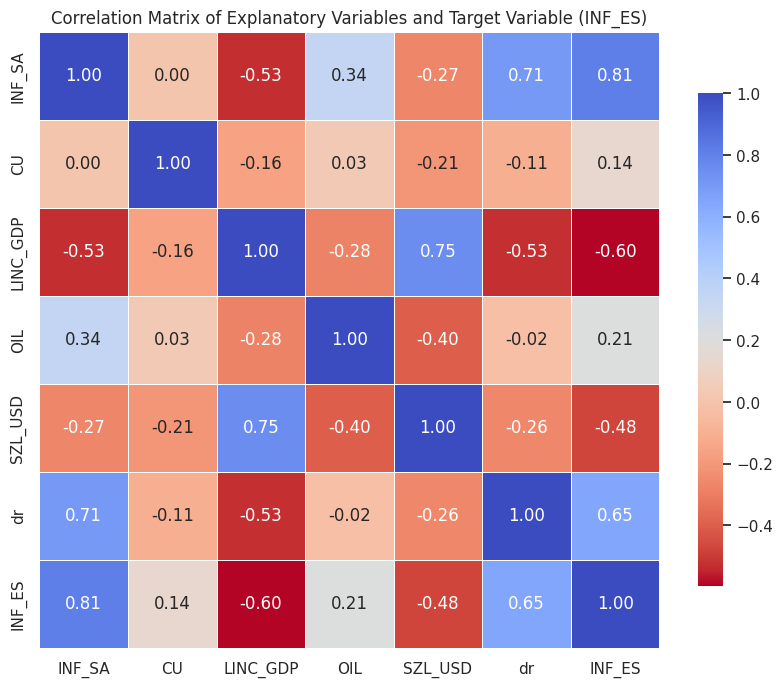

,INF_SA,CU,LINC_GDP,OIL,SZL_USD,dr,INF_ES
INF_SA,1.000000,0.004894,-0.529964,0.342557,-0.269019,0.705345,0.807395
CU,0.004894,1.000000,-0.164066,0.033200,-0.211087,-0.109623,0.139092
LINC_GDP,-0.529964,-0.164066,1.000000,-0.282399,0.752488,-0.525737,-0.595952
OIL,0.342557,0.033200,-0.282399,1.000000,-0.398228,-0.024081,0.208141
SZL_USD,-0.269019,-0.211087,0.752488,-0.398228,1.000000,-0.261481,-0.476102
dr,0.705345,-0.109623,-0.525737,-0.024081,-0.261481,1.000000,0.648404
INF_ES,0.807395,0.139092,-0.595952,0.208141,-0.476102,0.648404,1.000000


In [7]:
# Calculate the correlation matrix
correlation_matrix = data[explanatory_vars + [target_var]].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm_r', fmt=".2f", linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Explanatory Variables and Target Variable (INF_ES)')
plt.show()

# Display the correlation matrix for reference
correlation_matrix

In [7]:
data.describe()

,INF_SA,CU,LINC_GDP,OIL,SZL_USD,dr,INF_ES
count,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,5.719905,-0.001192,42.578942,75.692607,12.086842,6.476303,6.000981
std,1.933756,0.015528,0.517296,23.513633,3.833492,1.919209,2.543878
min,2.000000,-0.079761,41.264000,21.040000,6.700400,3.750000,1.600000
25%,4.600000,-0.007065,42.264700,57.405000,8.061900,5.125000,4.400000
50%,5.400000,0.000000,42.738350,74.730000,12.307200,6.500000,5.300000
75%,6.300000,0.007275,43.003355,97.330000,14.913400,7.250000,7.100000
max,13.800000,0.040000,43.126020,132.830000,19.070000,11.500000,14.697210


### Create and fit the regression model

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Load and prepare the data
def prepare_data(data):
    # Convert MONTH to datetime
    data['MONTH'] = pd.to_datetime(data['MONTH'].astype(str), format='%YM%m')
    
    # Create time-based features
    data['year'] = data['MONTH'].dt.year
    data['month'] = data['MONTH'].dt.month
    
    # Create lag features
    for col in ['INF_SA', 'CU', 'LINC_GDP', 'OIL', 'SZL_USD', 'dr']:
        for lag in [1, 2, 3, 6]:
            data[f'{col}_lag_{lag}'] = data[col].shift(lag)
    
    # Drop rows with NaN values
    data = data.dropna()
    
    return data

# Function to prepare a single prediction input
def prepare_prediction_input(input_values, historical_data, scaler):
    # Create a DataFrame with the input values
    input_df = pd.DataFrame([input_values], columns=['INF_SA', 'CU', 'LINC_GDP', 'OIL', 'SZL_USD', 'dr'])
    
    # Add month and year (using the last date from historical data)
    last_date = historical_data['MONTH'].iloc[-1]
    input_df['year'] = last_date.year
    input_df['month'] = last_date.month
    
    # Create lag features using historical data
    for col in ['INF_SA', 'CU', 'LINC_GDP', 'OIL', 'SZL_USD', 'dr']:
        for lag in [1, 2, 3, 6]:
            input_df[f'{col}_lag_{lag}'] = historical_data[col].iloc[-lag]
    
    # Ensure the columns are in the same order as during training
    input_df = input_df[features]
    
    # Scale the input using the same scaler
    input_scaled = scaler.transform(input_df)
    
    return input_scaled

# Load the Excel file
data = pd.read_excel('data_final.xlsx')
print(f"Data loaded successfully. Shape: {data.shape}")

# Prepare the data
prepared_data = prepare_data(data)
print(f"Data prepared successfully. Shape after preparation: {prepared_data.shape}")

# Define features and target
features = [col for col in prepared_data.columns if col not in ['MONTH', 'INF_ES']]
X = prepared_data[features]
y = prepared_data['INF_ES']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train the Random Forest model
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# Function to make prediction
def predict_inf_es(inp_INF_SA, inp_CU, inp_LINC_GDP, inp_OIL, inp_SZL_USD, inp_dr):
    input_values = {
        'INF_SA': inp_INF_SA,
        'CU': inp_CU,
        'LINC_GDP': inp_LINC_GDP,
        'OIL': inp_OIL,
        'SZL_USD': inp_SZL_USD,
        'dr': inp_dr
    }
    
    input_scaled = prepare_prediction_input(input_values, prepared_data, scaler)
    prediction = best_model.predict(input_scaled)[0]
    
    return prediction

# Model performance
print("\nModel Performance:")
y_pred_test = best_model.predict(X_test_scaled)
test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test R2 Score: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Example prediction
print("\nPrediction:")
example_prediction = predict_inf_es(
    inp_INF_SA=4.4,
    inp_CU=-0.048,
    inp_LINC_GDP=43.10713,
    inp_OIL=83.77,
    inp_SZL_USD=17.63,
    inp_dr=7.25
)
print(f"Predicted INF_ES: {example_prediction:.4f}")


Data loaded successfully. Shape: (211, 8)
Data prepared successfully. Shape after preparation: (205, 34)



Model Performance:
Test R2 Score: 0.9271
Test RMSE: 0.7785

Prediction:
Predicted INF_ES: 4.0730
